In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('fashion-mnist_train.csv')
data_test = pd.read_csv('fashion-mnist_test.csv')

In [3]:
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


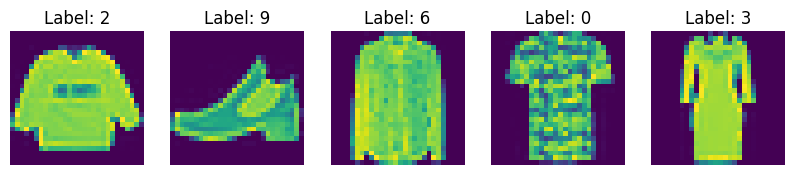

In [4]:
labels = data.iloc[:, 0].values  # .values convert to numpy arrays
pixels = data.iloc[:, 1:].values  # Remaining columns are pixel values (784 pixels for each image)

num_images_to_show = 5 
fig, axes = plt.subplots(1, num_images_to_show, figsize=(10, 2))

for i in range(num_images_to_show):
    ax = axes[i]
    ax.imshow(pixels[i].reshape(28, 28))  # Reshape and display as 28x28 image
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')
plt.show()

# Data Preprocessing

In [5]:
print(data.isnull().sum())

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64


In [6]:
train = data.to_numpy()
test = data_test.to_numpy()

In [7]:
ms = train.shape[0]  # Number of examples in training set
ns = train.shape[1]  # Number of pixels in training set
mt, nt = test.shape  # Number of samples and features in test set

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (60000, 785)
Test shape: (10000, 785)


#### Splitting data

In [8]:
# Split train data into features and labels
X_train = train[:, 1:ns]  # pixels (excluding the first column which is the label)
X_train = (X_train.T) / 255  # Normalize and transpose 

y_train = train[:, 0]  # Labels

#same for test set
X_test = test[:, 1:nt] 
X_test = (X_test.T) / 255  
y_test = test[:, 0] 

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (784, 60000)
y_train shape: (60000,)


#### Splitting into training and dev set

In [9]:
# Split the training data into training and development sets
split_ratio = 0.8  # 80% for training, 20% for development
train_size = int(ms * split_ratio)  # Number of training samples
dev_size = ms - train_size  # Number of development samples

# Create train and dev sets for features and labels
X_train_split = X_train[:, :train_size]  # First 80% of the samples for training
y_train_split = y_train[:train_size]  # Corresponding labels for training

X_dev_split = X_train[:, train_size:]  # Remaining 20% for development
y_dev_split = y_train[train_size:]  # Corresponding labels for development

# Print the shapes of the resulting datasets
print(f"X_train_split shape: {X_train_split.shape}")
print(f"y_train_split shape: {y_train_split.shape}")
print(f"X_dev_split shape: {X_dev_split.shape}")
print(f"y_dev_split shape: {y_dev_split.shape}")

X_train_split shape: (784, 48000)
y_train_split shape: (48000,)
X_dev_split shape: (784, 12000)
y_dev_split shape: (12000,)


In [10]:
m = X_train.shape[1]   #number of training examples
n = X_train.shape[0]   #number of features (pixels)
neuron1 = 256 #tried 397 but no noticeable difference observed
neuron2 = 10

# Neural Network Model

#### Initializing parameters

In [11]:
def init_params():
    W1 = np.random.rand(neuron1,n) * np.sqrt(2 / (n))  #He initialization
    b1 = np.zeros((neuron1,1))
    W2 = np.random.rand(neuron2,neuron1) * np.sqrt(2 / (neuron1))# He initialization
    b2 = np.zeros((neuron2,1))
    return W1,b1,W2,b2

#### Definining activation fucntion

In [12]:
def ReLU(z):
    return np.maximum(z,0)

def ReLU_deriv(z):
    return z>0

In [13]:
def softmax(z):
    return np.exp(z)/np.sum(np.exp(z),axis=0)

In [14]:
def compute_loss(A2, y):
    m = y.shape[0]  # Number of examples
    Y = np.eye(A2.shape[0])[y]  # Convert y into one-hot encoded form
    log_probs = -np.log(A2)  # Cross-entropy loss calculation
    loss = np.sum(log_probs * Y.T) / m  # Transpose Y to align with log_probs for multiplication
    return loss

#### One-hot Encoding

In [15]:
def one_hot(Y):
    m = Y.size  # number of examples
    init_one = np.zeros((neuron2, m))  # Create a matrix of shape (neuron2, m)
    
    for i in range(m):
        init_one[Y[i], i] = 1  # Set the appropriate position to 1
    #rows - labels
    #columns - examples
    return init_one

#### Forward Propagation

In [16]:
def forward_pass(W1,b1,W2,b2,X):
    Z1 = W1.dot(X) + b1    #(neuron1,m)
    A1 = ReLU(Z1)          #(neuron1,m)
    Z2 = W2.dot(A1) + b2   #y_hat  (neuron2,m)
    Z2 = (Z2 - np.mean(Z2))/(np.std(Z2)) 
    A2 = softmax(Z2)       #p(y_hat) (neuron2,m)
    return Z1, A1, Z2, A2

#### Backward Propagation

In [17]:
def crossentropy_backpropagation(Z1, A1, Z2, A2, W2, X, y):
    Y_one_hot = one_hot(y)
    
    dL_dZ2 = A2 - Y_one_hot            #(neuron2,m)
    dL_db2 = (1/m) * (np.sum(dL_dZ2, axis=1).reshape(neuron2,1))    #(neuron2,1)
    dL_dW2 = (1/m) * (dL_dZ2.dot(A1.T))         #(neuron2,neuron1)
    
    dL_dZ1 = W2.T.dot(dL_dZ2) * ReLU_deriv(Z1)  #(neuron1,m)
    dL_db1 = (1/m) * (np.sum(dL_dZ1, axis=1).reshape(neuron1,1))    #(neuron1,1)
    dL_dW1 = (1/m) * (dL_dZ1.dot(X.T))          #(neuron1,n)
    
    return dL_db2, dL_dW2, dL_db1, dL_dW1

#### Update Parameters

In [18]:
def update_parameters(W1,b1,W2,b2, dL_db1,dL_dW1, dL_db2,dL_dW2, alpha):
    W1 = W1 - alpha*dL_dW1
    b1 = b1 - alpha*dL_db1
    W2 = W2 - alpha*dL_dW2
    b2 = b2 - alpha*dL_db2
    return W1,b1,W2,b2

#### Predictions

In [19]:
def get_predictions(A2):
    return np.argmax(A2,0)
    
def get_accuracy(predictions,y):
    return np.sum(predictions == y)/y.size

#### Gradient Descent

In [21]:
def gradient_descent(X, y, X_dev, y_dev, epochs, alpha):
    W1, b1, W2, b2 = init_params()
    
    # List to store the loss values for each iteration
    loss_values = []
    
    for i in range(epochs):
        Z1, A1, Z2, A2 = forward_pass(W1, b1, W2, b2, X)
        
        # Calculate the loss (Cross-Entropy Loss) for training set
        loss = compute_loss(A2, y)  
        loss_values.append(loss)  # Store the loss
        
        # Backpropagation
        dL_db2, dL_dW2, dL_db1, dL_dW1 = crossentropy_backpropagation(Z1, A1, Z2, A2, W2, X, y) 
        
        # Update parameters
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dL_db1, dL_dW1, dL_db2, dL_dW2, alpha)
        
        if i % 100 == 0:
            train_accuracy = get_accuracy(get_predictions(A2), y)
            
            # Calculate dev set loss (without affecting training), dev doesn't get optimized as its parameter are not updated
            _, _, _, A2_dev = forward_pass(W1, b1, W2, b2, X_dev)
            dev_loss = compute_loss(A2_dev, y_dev)  # Calculate the loss on dev set
            dev_accuracy = get_accuracy(get_predictions(A2_dev), y_dev)
            
            print(f"Iteration: {i}  Train Accuracy = {train_accuracy:.4f}  Dev Accuracy = {dev_accuracy:.4f}")
            print(f"Train cost: {loss:.4f}  Dev cost: {dev_loss:.4f}")
            print('-'*40)
    
    plt.plot(range(epochs), loss_values, label='Training cost')
    plt.xlabel('Iteration')
    plt.ylabel('cost')
    plt.title('Cost vs Iteration')
    plt.legend()
    plt.show()
    
    return W1, b1, W2, b2, Z2, A2

# Training

- Slowed down with alpha 0.01 compared to 0.1 with dev accuracy 0.64 at 1500 iterations
- Iterations set to 1500 as seen converging and start to overfit beyond it
- Better result at 256 neurons than 128 in layer 1 with 84.09% accuracy for train
- No noticeable difference when trained at 397 neuron which is mean of input and output feature.

Iteration: 0  Train Accuracy = 0.0998  Dev Accuracy = 0.0973
Train cost: 2.4221  Dev cost: 6.1375
----------------------------------------
Iteration: 100  Train Accuracy = 0.6820  Dev Accuracy = 0.6927
Train cost: 0.9180  Dev cost: 0.8898
----------------------------------------
Iteration: 200  Train Accuracy = 0.7518  Dev Accuracy = 0.7432
Train cost: 0.7128  Dev cost: 0.7167
----------------------------------------
Iteration: 300  Train Accuracy = 0.7917  Dev Accuracy = 0.7798
Train cost: 0.6192  Dev cost: 0.6329
----------------------------------------
Iteration: 400  Train Accuracy = 0.8070  Dev Accuracy = 0.8021
Train cost: 0.5663  Dev cost: 0.5868
----------------------------------------
Iteration: 500  Train Accuracy = 0.8167  Dev Accuracy = 0.8129
Train cost: 0.5340  Dev cost: 0.5580
----------------------------------------
Iteration: 600  Train Accuracy = 0.8230  Dev Accuracy = 0.8199
Train cost: 0.5122  Dev cost: 0.5363
----------------------------------------
Iteration: 700 

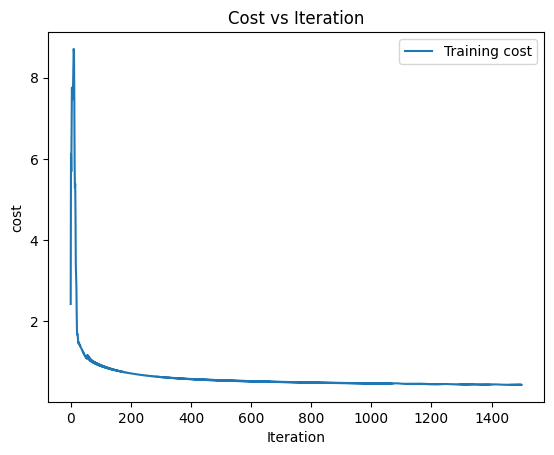

In [22]:
W1,b1,W2,b2,Z2,A2 = gradient_descent(X_train_split, y_train_split, X_dev_split, y_dev_split, 1501, 0.1)

# Testing

**Prediction**

In [27]:
def classification_report(y_true, y_pred):
    import numpy as np
    classes = np.unique(y_true)
    header = f"{'Class':<10}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}{'Support':<10}"
    print(header)
    print("-" * len(header))
    
    for cls in classes:
        true_positive = np.sum((y_pred == cls) & (y_true == cls))
        false_positive = np.sum((y_pred == cls) & (y_true != cls))
        false_negative = np.sum((y_pred != cls) & (y_true == cls))
        support = np.sum(y_true == cls)
        
        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"{cls:<10}{precision:<10.2f}{recall:<10.2f}{f1_score:<10.2f}{support:<10}")

In [28]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_pass(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)  # Returns class indices
    return predictions

def evaluate_model(W1, b1, W2, b2, X_test, y_test):
    predictions = make_predictions(X_test, W1, b1, W2, b2)
    print("Classification Report:")
    print(classification_report(y_test, predictions))  # Assumes `classification_report` is defined

def test_prediction(index, W1, b1, W2, b2, X_test, y_test):
    current_image = X_test[:, index, None]
    prediction = make_predictions(current_image, W1, b1, W2, b2)
    label = y_test[index]
    
    print('Prediction:', prediction[0])  # `prediction` is a single-element array
    print('Label:', label)
    
    # Visualize the image
    current_image = current_image.reshape((28, 28))
    plt.figure(figsize=(2,2))
    plt.imshow(current_image, interpolation='nearest')
    plt.show()
    
def confusion_matrix(y_true, y_pred, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    for true_label, predicted_label in zip(y_true, y_pred):
        matrix[true_label, predicted_label] += 1
    
    return matrix

def plot_confusion_matrix(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred, num_classes)
    
    # Use seaborn to plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

Prediction: 9
Label: 9


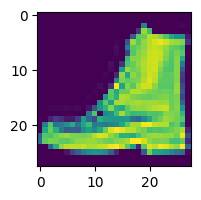

In [29]:
test_prediction(67, W1, b1, W2, b2, X_test, y_test)

Test Accuracy:  0.8499
Class     Precision Recall    F1-Score  Support   
--------------------------------------------------
0         0.78      0.84      0.81      1000      
1         0.96      0.97      0.97      1000      
2         0.77      0.76      0.76      1000      
3         0.86      0.88      0.87      1000      
4         0.69      0.91      0.79      1000      
5         0.93      0.91      0.92      1000      
6         0.79      0.44      0.56      1000      
7         0.91      0.90      0.90      1000      
8         0.93      0.95      0.94      1000      
9         0.91      0.94      0.93      1000      


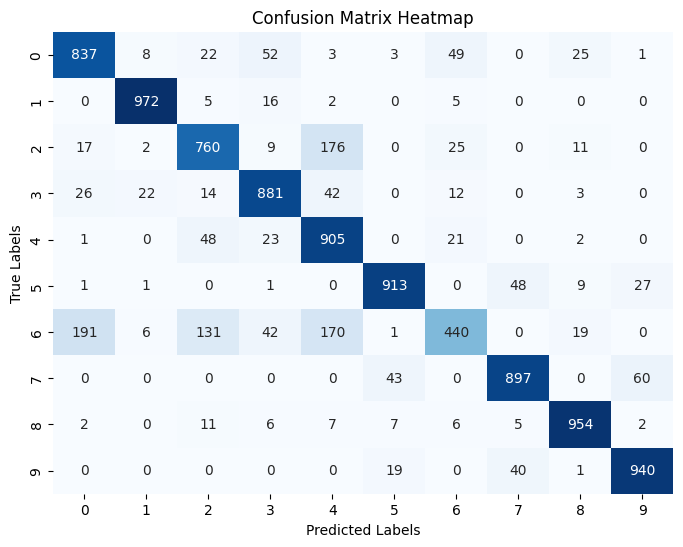

In [31]:
Z1, A1, Z2, A2 = forward_pass(W1,b1,W2,b2,X_test)
print("Test Accuracy: ", get_accuracy(get_predictions(A2),y_test))
predictions = make_predictions(X_test, W1, b1, W2, b2)  # Predicted labels
classification_report(y_test, predictions)  # Compare against true labels
plot_confusion_matrix(y_test, predictions, num_classes=10)
